In [1]:
import pandas as pd
import boto3
from matplotlib import pyplot as plt
from cleodata.utils.secrets import get_secret
from cleodata.sources.sync.sync import SyncDataSource
boto3.setup_default_session(profile_name='DataScientist-878877078763')
redshift_source = SyncDataSource("data_exploration", use_redshift=True, redshift_cluster="cleo-production-redshift", redshift_db="cleo")

Attempting to uninstrument while already uninstrumented


2024-05-15 14:45:10 [debug    ] fetching credentials          
2024-05-15 14:45:12 [info     ] Credentials acquired          
2024-05-15 14:45:12 [info     ] Built connection pool         


# Overall data

In [12]:
sql = """ 
select tt.corrected_made_on, count(*)
from analytics.fct_transactions tt
where tt.corrected_made_on between '2024-04-01' and '2024-04-30'
group by tt.corrected_made_on
"""
tr_by_dates = redshift_source.fetch_data(sql)#.iloc[0]['count']

<Axes: >

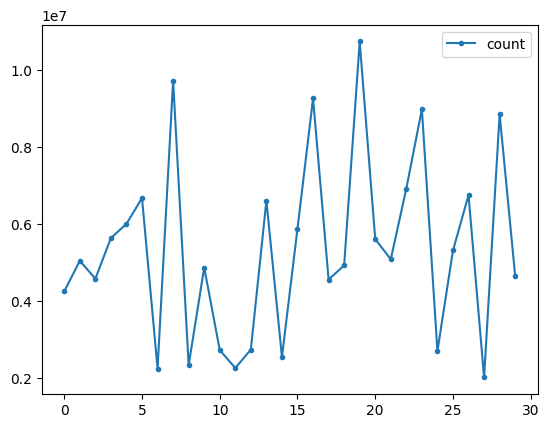

In [13]:
tr_by_dates.plot(marker='.')

In [20]:
tr_by_dates

,corrected_made_on,count
0,2024-04-23,4248921
1,2024-04-02,5042765
2,2024-04-09,4577349
3,2024-04-25,5634160
4,2024-04-04,6000063
5,2024-04-26,6671077
6,2024-04-14,2246245
7,2024-04-15,9712028
8,2024-04-07,2335506
9,2024-04-10,4866791


In [49]:
def plot_number_trans(df):
    df.sort_values(by='corrected_made_on', inplace=True)
    plt.figure(figsize=(10, 3))
    plt.plot(df['corrected_made_on'], df['count'], '-')
    plt.title('Number of transaction created each day')
    plt.show()


def plot_trans_per_day_of_week(df):
    import calendar
    df['day_of_week'] = df['corrected_made_on'].apply(lambda x: x.weekday())
    df.sort_values(by='corrected_made_on', inplace=True)

    plt.figure(figsize=(10, 3))
    plt.plot(df['day_of_week'], df['count'], '.')
    plt.title('Number of transaction created each day')
    plt.show()

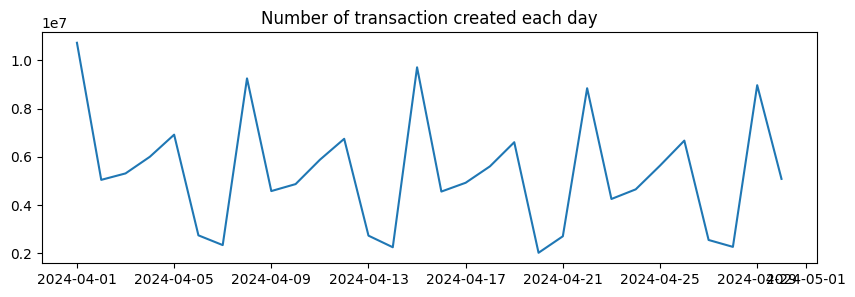

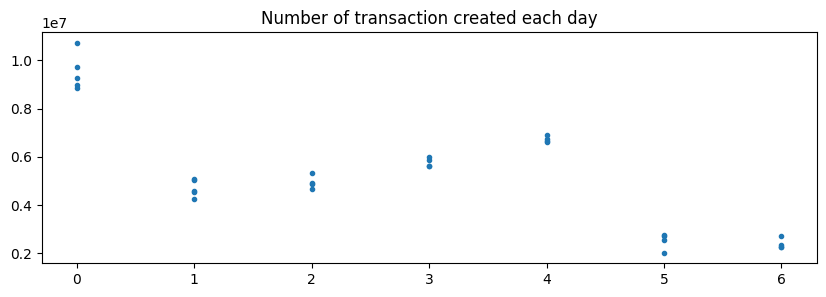

In [50]:
plot_number_trans(tr_by_dates)
plot_trans_per_day_of_week(tr_by_dates)
# 0 Is Monday

Mondays are the days with most transactions.

Saturdays and sundays are the days with less transactions

In [42]:
# Let's look if the income/outcome has a different pattern 

sql = """ 
select tt.corrected_made_on, count(*)
from analytics.fct_transactions tt
where tt.corrected_made_on between '2024-04-01' and '2024-04-30'
and amount > 0
group by tt.corrected_made_on
"""
tr_by_dates_incoming = redshift_source.fetch_data(sql)#.iloc[0]['count']

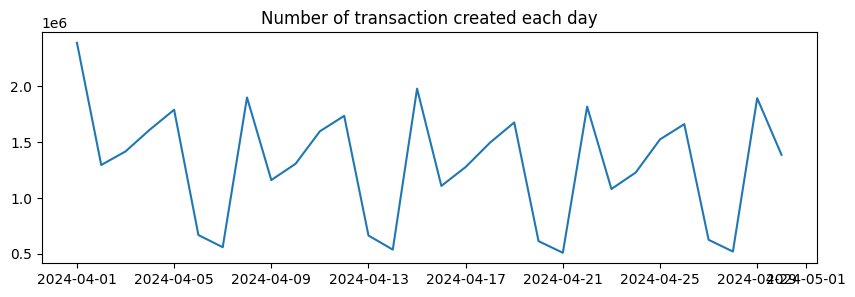

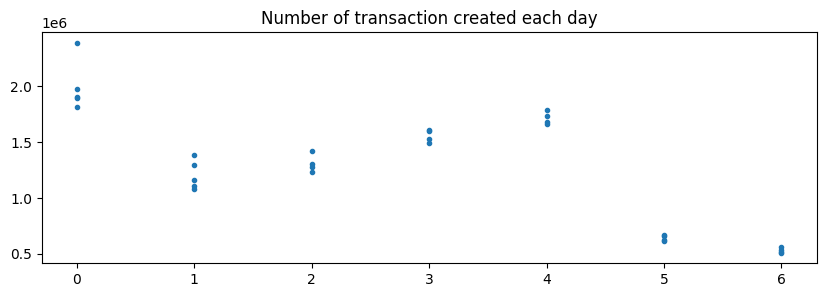

In [51]:
plot_number_trans(tr_by_dates_incoming)
plot_trans_per_day_of_week(tr_by_dates_incoming)

In [52]:
# Let's look if the income/outcome has a different pattern 

sql = """ 
select tt.corrected_made_on, count(*)
from analytics.fct_transactions tt
where tt.corrected_made_on between '2024-04-01' and '2024-04-30'
and amount < 0
group by tt.corrected_made_on
"""
tr_by_dates_out = redshift_source.fetch_data(sql)#.iloc[0]['count']

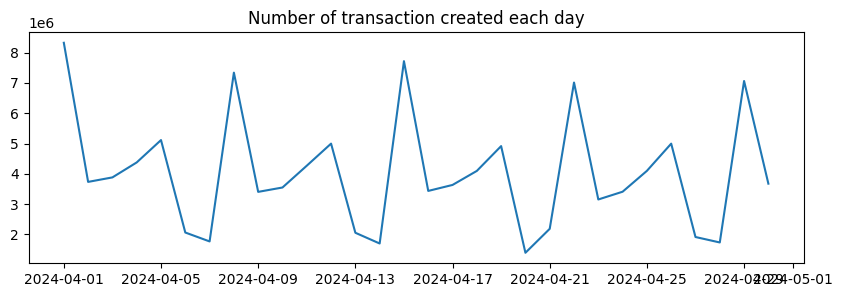

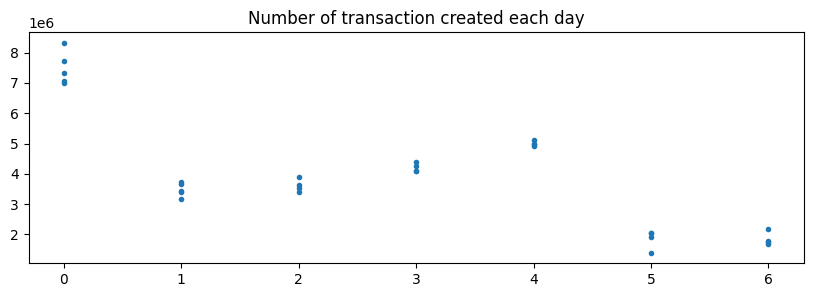

In [53]:
plot_number_trans(tr_by_dates_out)
plot_trans_per_day_of_week(tr_by_dates_out)

In [55]:
tr_by_dates_out.head()

,corrected_made_on,count,day_of_week
28,2024-04-01,8322503,0
6,2024-04-02,3734510,1
24,2024-04-03,3882534,2
16,2024-04-04,4376200,3
8,2024-04-05,5113832,4


In [56]:
tr_by_dates.head()

,corrected_made_on,count,day_of_week
19,2024-04-01,10731028,0
1,2024-04-02,5042765,1
25,2024-04-03,5310230,2
4,2024-04-04,6000063,3
22,2024-04-05,6917770,4


# Merchant data

### Total transaction between '2023-04-25' and '2024-04-25'

In [16]:
sql = """ 
select count(*)
from analytics.fct_transactions tt
where tt.corrected_made_on between '2023-04-25' and '2024-04-25'
"""

In [17]:
n_total = redshift_source.fetch_data(sql).iloc[0]['count']
n_total

2534573348

In [29]:
n_total/1000000

2534.573348

### Total transaction without merchant found between '2023-04-25' and '2024-04-25'

In [30]:
sql = """ 
select count(*)
from analytics.fct_transactions tt
where tt.corrected_made_on between '2023-04-25' and '2024-04-25' and tt.merchant_id is null
"""

In [31]:
n_nomerchant = redshift_source.fetch_data(sql).iloc[0]['count']
n_nomerchant

OperationalError: (psycopg2.OperationalError) connection to server at "cleo-production-redshift.cdeo52gmemam.us-east-1.redshift.amazonaws.com" (10.0.0.35), port 5439 failed: FATAL:  IAM Authentication token has expired

(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [20]:
round(n_nomerchant / n_total * 100, 2)

25.15

### Transactions with merchant

In [22]:
sql = """ 
with 
counts_for_merchants as (
select
     tt.merchant_id as id,
     
     sum(case when tt.amount > 0 then 1 else 0 end) as count__total_in,
     sum(case when tt.amount < 0 then 1 else 0 end) as count__total_out,
     sum(case when tt.amount = 0 then 1 else 0 end) as count__total_zero,
     
     sum(case when tt.amount > 0 then tt.amount else 0 end) as sum_total_in,
     sum(case when tt.amount < 0 then tt.amount else 0 end) as sum_total_out,

     count(distinct tt.user_id) as users_count
     
from analytics.fct_transactions tt
where tt.corrected_made_on between '2023-04-25' and '2024-04-25' and tt.merchant_id is not null
group by tt.merchant_id
)

select 
    m.id,
    m.name,
    m.twitter_name,
    m.website,
    m.transaction_category_id,
    m.categorized_by_admin,
    m.origin,
     
    c.count__total_in,
    c.count__total_out,
    c.count__total_zero,
    c.sum_total_in,
    c.sum_total_out,
    c.users_count
        
from merchants m
join counts_for_merchants c on c.id = m.id
"""

In [23]:
dfc =redshift_source.fetch_data(sql)

In [24]:
dfc.shape

(2801643, 13)

In [25]:
dfc.columns

Index(['id', 'name', 'twitter_name', 'website', 'transaction_category_id',
       'categorized_by_admin', 'origin', 'count__total_in', 'count__total_out',
       'count__total_zero', 'sum_total_in', 'sum_total_out', 'users_count'],
      dtype='object')

In [34]:
dfc.sort_values('count__total_in').tail(10)

,id,name,twitter_name,website,transaction_category_id,categorized_by_admin,origin,count__total_in,count__total_out,count__total_zero,sum_total_in,sum_total_out,users_count
2788650,6607063,Save Your Change,None,None,17.0,False,PlaidLogin,7332380,7428053,0,3091626.11,-3131306.46,41018
2684906,5457335,Empower,empowerhq,None,18.0,False,PlaidLogin,8290231,16340086,17252,1163226845.03,-1316925750.18,1229561
2791648,6343702,Brigit,hellobrigitapp,None,18.0,False,PlaidLogin,8723493,13126632,27316,469813574.15,-549180594.38,1115295
2654075,3779957,Online Banking Transfer,None,None,14.0,False,PlaidLogin,11140482,10167356,3,1754428073.72,-1518657967.96,136861
2789014,11275357,MoneyLion,moneylion,None,18.0,False,PlaidLogin,11911760,8062930,8804,1027544951.45,-1323503132.26,574583
2795208,1115910,Cash App,cashapp,None,14.0,False,PlaidLogin,15680599,5880493,109741,1040264669.43,-414171295.83,1077588
2731552,1224309,Earnin,earnin,None,18.0,False,PlaidLogin,19743527,17532677,28441,1554089342.69,-1577799108.74,840631
2759212,15623830,Builder,None,None,NaN,False,PlaidLogin,20347493,16682559,0,2444788456.92,-3938896868.32,416904
2550234,1766413,Round Up,chime,None,17.0,False,PlaidLogin,29265145,31293531,98,14401163.74,-16284398.76,337081
2740917,1206735,Savings,None,None,17.0,False,SaltEdgeLogin,63524310,30756695,107,4906022817.93,-5063513960.58,892444


In [35]:
dfc.sort_values('count__total_out').tail(10)

,id,name,twitter_name,website,transaction_category_id,categorized_by_admin,origin,count__total_in,count__total_out,count__total_zero,sum_total_in,sum_total_out,users_count
2789192,97649,Cleo,meetcleo,None,18.0,False,SaltEdgeLogin,6321564,17407176,19025,364507432.04,-470287022.83,1330357
2731552,1224309,Earnin,earnin,None,18.0,False,PlaidLogin,19743527,17532677,28441,1554089342.69,-1577799108.74,840631
2752117,6,Uber,uber,None,15.0,False,SaltEdgeLogin,2594657,20375591,74367,137058318.53,-318316697.02,876408
2757168,5,Amazon,amazon,http://www.amazon.co.uk,13.0,False,SaltEdgeLogin,2258772,26762452,39709,259187361.98,-906826579.09,1443661
2740917,1206735,Savings,None,None,17.0,False,SaltEdgeLogin,63524310,30756695,107,4906022817.93,-5063513960.58,892444
2550234,1766413,Round Up,chime,None,17.0,False,PlaidLogin,29265145,31293531,98,14401163.74,-16284398.76,337081
2727618,12,McDonald''s,mcdonalds,None,5.0,False,SaltEdgeLogin,213521,32556729,20834,8654919.97,-400602601.83,1871040
2801583,1793,Apple,apple,None,13.0,False,SaltEdgeLogin,866441,37710390,34188,31669977.12,-674042829.33,1299542
2646392,266180,Walmart,walmart,None,9.0,False,SaltEdgeLogin,2624510,38456046,44516,466405308.47,-2168003173.15,1815731
2646374,123003,Cash Withdrawal,None,None,4.0,False,SaltEdgeLogin,202606,40124228,3147,10363714.78,-4484140597.88,1537569


# Analyse

In [27]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats

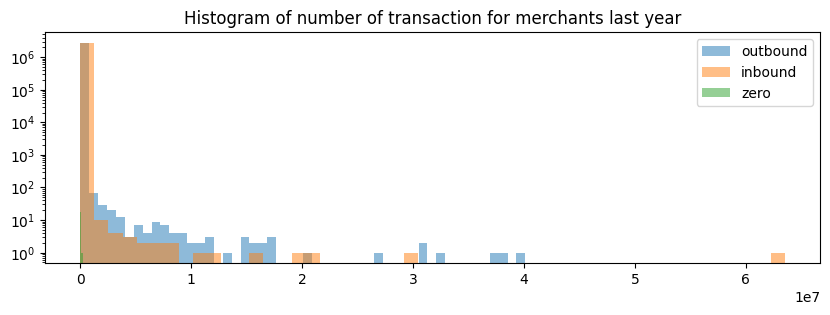

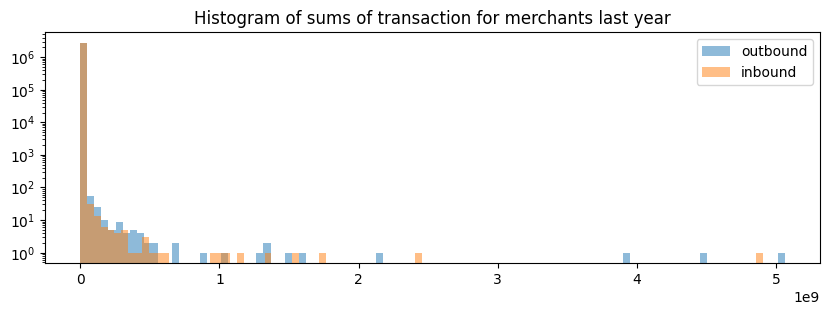

In [31]:
plt.figure(figsize=(10, 3))
plt.hist(dfc['count__total_out'], log=True, bins=50, alpha=0.5)
plt.hist(dfc['count__total_in'], log=True, bins=50, alpha=0.5)
plt.hist(dfc['count__total_zero'], log=True, bins=50, alpha=0.5)
plt.legend(['outbound', 'inbound', 'zero'])
plt.title('Histogram of number of transaction for merchants last year')
plt.show()

plt.figure(figsize=(10, 3))
plt.hist(-dfc['sum_total_out'], log=True, bins=100, alpha=0.5)
plt.hist(dfc['sum_total_in'], log=True, bins=100, alpha=0.5)
plt.legend(['outbound', 'inbound'])
plt.title('Histogram of sums of transaction for merchants last year')
plt.show()

In [36]:
dfc[dfc['id'].isin({123003 , 15623830, 1206735})]['name']

2646374    Cash Withdrawal
2740917            Savings
2759212            Builder
Name: name, dtype: object

In [46]:
dfc.drop(columns=['sums_percentile_in'], inplace=True) 

In [47]:
dfc.columns

Index(['id', 'name', 'twitter_name', 'website', 'transaction_category_id',
       'categorized_by_admin', 'origin', 'count__total_in', 'count__total_out',
       'count__total_zero', 'sum_total_in', 'sum_total_out', 'users_count'],
      dtype='object')

In [48]:
def get_percentile(percentile_col, value_col):
    dfc.sort_values(value_col, ascending=True, inplace=True, key=lambda x: abs(x))
    sums_index = dfc[~dfc['id'].isin({123003 , 15623830, 1206735})].index
    dfc[percentile_col] = None
    dfc.loc[sums_index,percentile_col] = np.abs(dfc.loc[sums_index,value_col].values).cumsum()/np.abs(dfc.loc[sums_index,value_col].values).sum()

In [49]:
get_percentile(percentile_col='sum_percentile_in', value_col='sum_total_in')
get_percentile(percentile_col='sum_percentile_out', value_col='sum_total_out')
get_percentile(percentile_col='count_percentile_in', value_col='count__total_in')
get_percentile(percentile_col='count_percentile_out', value_col='count__total_out')
get_percentile(percentile_col='count_percentile_zero', value_col='count__total_zero')

In [53]:
dfc.sort_values('sum_percentile_in')[-13:-3]

,id,name,twitter_name,website,transaction_category_id,categorized_by_admin,origin,count__total_in,count__total_out,count__total_zero,sum_total_in,sum_total_out,users_count,sum_percentile_in,sum_percentile_out,count_percentile_in,count_percentile_out,count_percentile_zero
2757179,16679849,Bank of America ATM,bankofamerica,None,1.0,False,PlaidLogin,1460081,1830893,0,503271259.39,-384280804.35,147769,0.7070779910611458041002085017,0.7015179234350511079209182807,0.296264,0.415033,0.0
2740975,9139058,Daily Pay,dailypay,None,11.0,False,PlaidLogin,4008935,1480,18977,577985195.07,-193602.95,97058,0.7238443118509878470414755808,0.1361435200676468342687554128,0.418845,0.103261,0.384005
2740895,994728,Venmo,venmo,None,14.0,False,PlaidLogin,5194550,10501443,16145,629554432.99,-1051211125.54,646179,0.7421065643588554553458749612,0.8423783301722336720686331001,0.480271,0.72054,0.348501
2685015,1146411,Dave Inc,davebanking,None,18.0,False,PlaidLogin,6998024,16957883,41509,978494843.80,-1266447367.37,1306595,0.7704909565237279050337029542,0.8641439200403230533590657538,0.535472,0.84046,0.520255
2789014,11275357,MoneyLion,moneylion,None,18.0,False,PlaidLogin,11911760,8062930,8804,1027544951.45,-1323503132.26,574583,0.8002982049254916565760407011,0.9095232177606808958355906668,0.731906,0.65321,0.297525
2795208,1115910,Cash App,cashapp,None,14.0,False,PlaidLogin,15680599,5880493,109741,1040264669.43,-414171295.83,1077588,0.8304744296848300572232395881,0.7360797966313740307443752247,0.796892,0.559778,0.680269
2684906,5457335,Empower,empowerhq,None,18.0,False,PlaidLogin,8290231,16340086,17252,1163226845.03,-1316925750.18,1229561,0.8642175680930151277665204260,0.8867770483515839809709343138,0.600217,0.828279,0.359744
2756927,3022904,Social Security Administration,socialsecurity,None,11.0,False,PlaidLogin,1236995,670,593,1372308888.69,-215917.02,137635,0.9040258040941839820471005098,0.1395173992638270042242009412,0.274291,0.075408,0.12507
2731552,1224309,Earnin,earnin,None,18.0,False,PlaidLogin,19743527,17532677,28441,1554089342.69,-1577799108.74,840631,0.9491071672119012217166742304,0.9627399692120698631655459201,0.878716,0.865559,0.444893
2654075,3779957,Online Banking Transfer,None,None,14.0,False,PlaidLogin,11140482,10167356,3,1754428073.72,-1518657967.96,136861,1,0.9356233837305994252878393054,0.68254,0.705675,0.010883


In [52]:
dfc.sort_values('count_percentile_in')[-13:-3]

,id,name,twitter_name,website,transaction_category_id,categorized_by_admin,origin,count__total_in,count__total_out,count__total_zero,sum_total_in,sum_total_out,users_count,sum_percentile_in,sum_percentile_out,count_percentile_in,count_percentile_out,count_percentile_zero
2789192,97649,Cleo,meetcleo,None,18.0,False,SaltEdgeLogin,6321564,17407176,19025,364507432.04,-470287022.83,1330357,0.6404119250242232647361640823,0.7591109058442013257030120465,0.50647,0.852964,0.390313
2685015,1146411,Dave Inc,davebanking,None,18.0,False,PlaidLogin,6998024,16957883,41509,978494843.80,-1266447367.37,1306595,0.7704909565237279050337029542,0.8641439200403230533590657538,0.535472,0.84046,0.520255
2788650,6607063,Save Your Change,None,None,17.0,False,PlaidLogin,7332380,7428053,0,3091626.11,-3131306.46,41018,0.1992583450138536281781210212,0.2366278947432254117237758363,0.56586,0.614046,0.0
2684906,5457335,Empower,empowerhq,None,18.0,False,PlaidLogin,8290231,16340086,17252,1163226845.03,-1316925750.18,1229561,0.8642175680930151277665204260,0.8867770483515839809709343138,0.600217,0.828279,0.359744
2791648,6343702,Brigit,hellobrigitapp,None,18.0,False,PlaidLogin,8723493,13126632,27316,469813574.15,-549180594.38,1115295,0.6924789884375256363092869177,0.7856938585618527079776692165,0.63637,0.762298,0.426113
2654075,3779957,Online Banking Transfer,None,None,14.0,False,PlaidLogin,11140482,10167356,3,1754428073.72,-1518657967.96,136861,1,0.9356233837305994252878393054,0.68254,0.705675,0.010883
2789014,11275357,MoneyLion,moneylion,None,18.0,False,PlaidLogin,11911760,8062930,8804,1027544951.45,-1323503132.26,574583,0.8002982049254916565760407011,0.9095232177606808958355906668,0.731906,0.65321,0.297525
2795208,1115910,Cash App,cashapp,None,14.0,False,PlaidLogin,15680599,5880493,109741,1040264669.43,-414171295.83,1077588,0.8304744296848300572232395881,0.7360797966313740307443752247,0.796892,0.559778,0.680269
2731552,1224309,Earnin,earnin,None,18.0,False,PlaidLogin,19743527,17532677,28441,1554089342.69,-1577799108.74,840631,0.9491071672119012217166742304,0.9627399692120698631655459201,0.878716,0.865559,0.444893
2550234,1766413,Round Up,chime,None,17.0,False,PlaidLogin,29265145,31293531,98,14401163.74,-16284398.76,337081,0.2895561260751562409720221916,0.3404361986439244816695146848,1.0,0.9219,0.05702


### Percentile for inbound transaction by counts

In [59]:
dfc.sort_values('count_percentile_in', inplace=True)
[(10**i, round(100*(1-dfc.iloc[-10**i-3]['count_percentile_in']), 1)) for i in range(1, 7)]

[(10, 49.4),
 (100, 84.9),
 (1000, 93.9),
 (10000, 97.7),
 (100000, 99.7),
 (1000000, 100.0)]

### Percentile for inbound transaction by amounts

In [66]:
dfc.sort_values('sum_percentile_in', inplace=True)
[(10**i, round(100*(1-dfc.iloc[-10**i-3]['sum_percentile_in']), 1)) for i in range(1, 7)]

[(10, Decimal('29.3')),
 (100, Decimal('64.1')),
 (1000, Decimal('82.2')),
 (10000, Decimal('93.4')),
 (100000, Decimal('99.8')),
 (1000000, Decimal('100.0'))]

### Percentile for outbound transaction by counts

In [67]:
dfc.sort_values('count_percentile_out', inplace=True)
[(10**i, round(100*(1-dfc.iloc[-10**i-3]['count_percentile_out']), 1)) for i in range(1, 7)]

[(10, 17.2),
 (100, 56.9),
 (1000, 78.2),
 (10000, 86.6),
 (100000, 93.7),
 (1000000, 99.5)]

### Percentile for outbound transaction by amounts

In [69]:
dfc.sort_values('sum_percentile_out', inplace=True)
[(10**i, round(100*(1-dfc.iloc[-10**i-3]['sum_percentile_out']), 1)) for i in range(1, 7)]

[(10, Decimal('20.3')),
 (100, Decimal('51.4')),
 (1000, Decimal('74.7')),
 (10000, Decimal('86.1')),
 (100000, Decimal('93.7')),
 (1000000, Decimal('99.4'))]

### Percentile for zero-amount transaction by counts

In [61]:
dfc.sort_values('count_percentile_zero', inplace=True)
[(10**i, round(100*(1-dfc.iloc[-10**i-3]['count_percentile_zero']), 1)) for i in range(1, 7)]

[(10, 46.5),
 (100, 78.6),
 (1000, 93.4),
 (10000, 98.8),
 (100000, 100.0),
 (1000000, 100.0)]